# 01   Task‑A   
# 01  Data understanding, visualization, event discovery & Task‑A labels

In [1]:
# :  utils/ Python 
#Adjustable: Add parent directory (which contains utils/) to Python search path
import sys, os
sys.path.append(os.path.abspath(".."))  #  notebooks  sys.path

In [2]:
#  cell  import
#Unified imports and path config (later cells avoid repeated imports)
import json, math, warnings, random
import numpy as np, pandas as pd
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker as mtick
from matplotlib import dates as mdates
from matplotlib.colors import LogNorm
import folium
from folium.plugins import HeatMap, MarkerCluster

from utils.config import set_data_dir, set_output_dirs, DATA_DIR, INTERIM_DIR, PROCESSED_DIR
from utils.etl_clean import ensure_interim, build_samples_taskA
from utils.trade_rebuild import infer_trades_from_port_calls, calibrate_with_official

from IPython.display import Markdown, display

sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (10,4)

print("DATA_DIR     =", DATA_DIR)
print("INTERIM_DIR  =", INTERIM_DIR)
print("PROCESSED_DIR=", PROCESSED_DIR)

DATA_DIR     = /Users/wangwei/Documents/Folders/工作/Kpler/data/raw
INTERIM_DIR  = /Users/wangwei/Documents/Folders/工作/Kpler/data/interim
PROCESSED_DIR= /Users/wangwei/Documents/Folders/工作/Kpler/data/processed


In [3]:
sns.set_theme(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (10, 4)

** port_calls cleaned parquet**  
**Read & clean port_calls, generate cleaned parquet**

In [4]:
df_port_calls = ensure_interim()
print("Cleaned port_calls:", df_port_calls.shape)

Cleaned port_calls: (347250, 14)


** trades & vessels EDA**  
**Load trades & vessels for EDA**

In [5]:
df_trades  = pl.read_csv(DATA_DIR / "trades.csv",  try_parse_dates=True)
df_vessels = pl.read_csv(DATA_DIR / "vessels.csv", try_parse_dates=True)
print("trades:", df_trades.shape, " | vessels:", df_vessels.shape)

trades: (240038, 9)  | vessels: (8902, 8)


**EDA Top-N**  
**EDA: Top‑N busiest ports**

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/2919439334.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ports_df, x="calls", y=PORT_COL, palette="viridis")


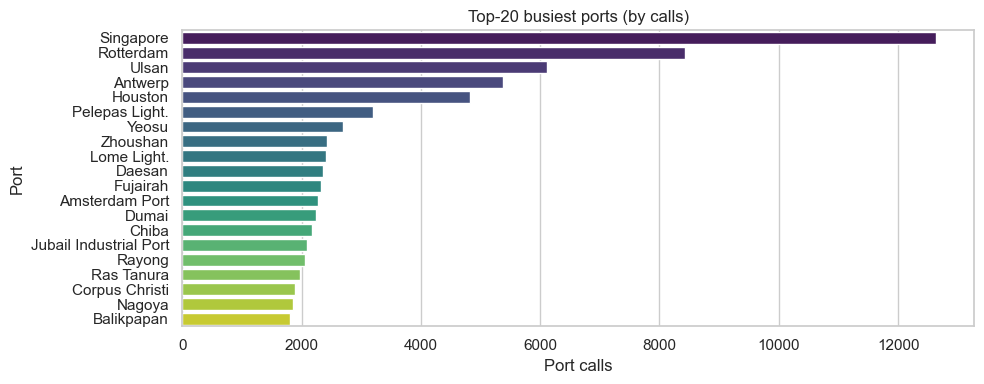

In [6]:
# : Top-N
#Adjustable: Top-N
TOP_N = 20
PORT_COL = "destination" if "destination" in df_port_calls.columns else None

if PORT_COL:
    top_ports_df = (
        df_port_calls.group_by(PORT_COL).len()
        .sort("len", descending=True).head(TOP_N)
        .rename({"len":"calls"})
        .to_pandas()
    )
    plt.figure(figsize=(10,4))
    sns.barplot(data=top_ports_df, x="calls", y=PORT_COL, palette="viridis")
    plt.title(f"Top-{TOP_N} busiest ports (by calls)")
    plt.xlabel("Port calls"); plt.ylabel("Port")
    plt.tight_layout(); plt.show()
else:
    print("No destination column; skip.")

**EDA: Dwell time dist. + Long‑stay ratio (by port)**

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/749991567.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=port_long, x="long_ratio", y=PORT_COL, ax=ax[1], palette="crest")


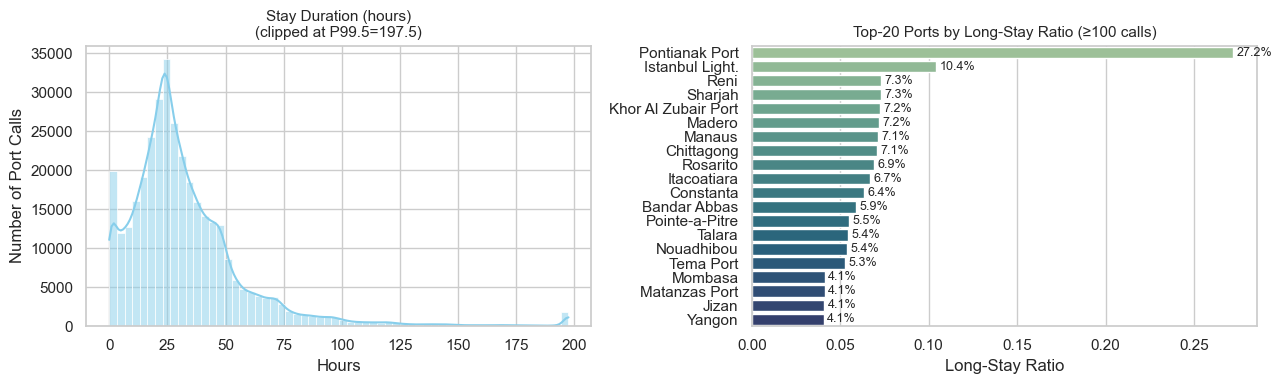

In [7]:
if "dur_h" in df_port_calls.columns:
    p995 = df_port_calls.select(pl.col("dur_h").quantile(0.995)).item()
    pdf = df_port_calls.select(
        pl.col("dur_h").clip(0, p995).alias("dur_h_clip"),
        pl.col("is_long_stay_outlier")
    ).to_pandas()

    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    sns.histplot(pdf["dur_h_clip"], bins=60, color="skyblue", ax=ax[0], kde=True)
    ax[0].set_title(f"Stay Duration (hours)\n(clipped at P99.5={p995:.1f})", fontsize=11)
    ax[0].set_xlabel("Hours"); ax[0].set_ylabel("Number of Port Calls")

    if PORT_COL:
        port_long = (
            df_port_calls.group_by(PORT_COL)
            .agg(total = pl.len(), long = pl.col("is_long_stay_outlier").sum())
            .with_columns((pl.col("long") / pl.col("total")).alias("long_ratio"))
            .filter(pl.col("total") >= 100)
            .sort("long_ratio", descending=True).head(20)
            .to_pandas()
        )
        sns.barplot(data=port_long, x="long_ratio", y=PORT_COL, ax=ax[1], palette="crest")
        ax[1].set_title("Top-20 Ports by Long-Stay Ratio (≥100 calls)", fontsize=11)
        ax[1].set_xlabel("Long-Stay Ratio"); ax[1].set_ylabel("")
        for i, (val, port) in enumerate(zip(port_long["long_ratio"], port_long[PORT_COL])):
            ax[1].text(val + 0.002, i, f"{val:.1%}", va="center", fontsize=9)

    plt.tight_layout(); plt.show()
else:
    print("Column 'dur_h' not found — run ensure_interim() first.")

**EDA: Geographic distribution (hexbin)**

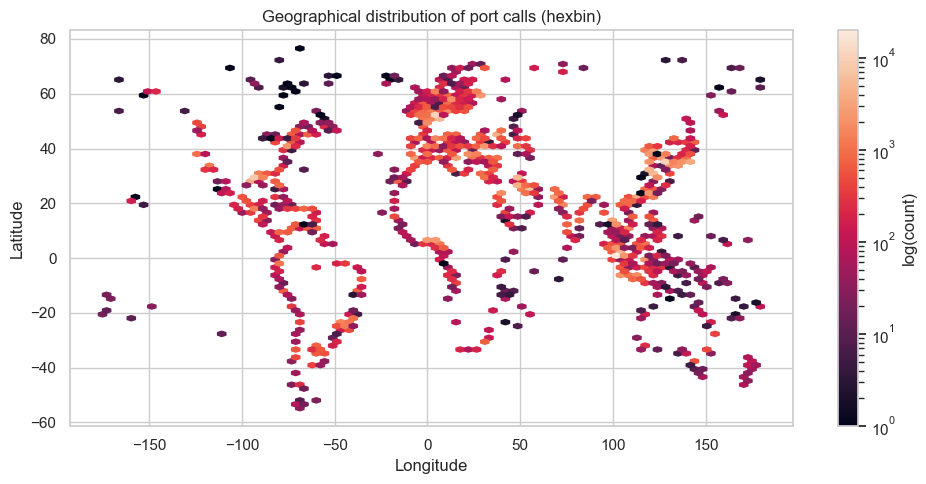

In [8]:
LAT_COL  = "destination_latitude"  if "destination_latitude"  in df_port_calls.columns else None
LON_COL  = "destination_longitude" if "destination_longitude" in df_port_calls.columns else None

if LAT_COL and LON_COL:
    geo = (df_port_calls
        .select([pl.col(LAT_COL).alias("lat"), pl.col(LON_COL).alias("lon")])
        .drop_nulls()
        .filter((pl.col("lat").is_between(-90,90)) & (pl.col("lon").is_between(-180,180)))
        .to_pandas())
    plt.figure(figsize=(10,5))
    plt.hexbin(geo["lon"], geo["lat"], gridsize=80, bins="log")
    plt.colorbar(label="log(count)")
    plt.title("Geographical distribution of port calls (hexbin)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()
else:
    print("No lat/lon columns found; skip geo plot.")

**EDA**  
**EDA: Seasonality (monthly calls & trade volume)**

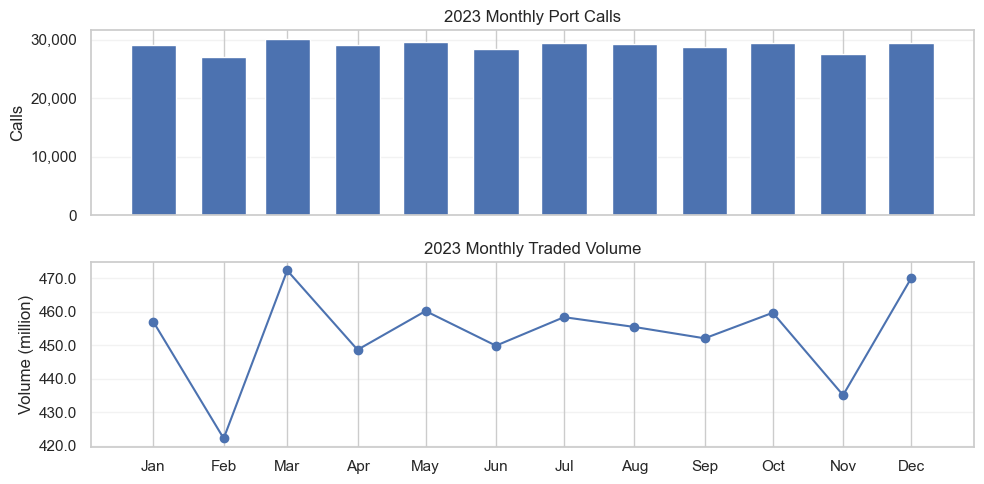

In [9]:
monthly_calls = (
    df_port_calls
    .with_columns(pl.col("start_utc").dt.truncate("1mo").alias("month"))
    .group_by("month").len().sort("month").to_pandas().rename(columns={"len":"calls"})
)
if set(["start_date_time","traded_volume"]).issubset(set(df_trades.columns)):
    monthly_vol = (
        df_trades.with_columns(pl.col("start_date_time").dt.truncate("1mo").alias("month"))
        .group_by("month").agg(pl.col("traded_volume").sum().alias("traded_volume"))
        .sort("month").to_pandas()
    )
else:
    monthly_vol = pd.DataFrame({"month": pd.to_datetime([]), "traded_volume":[]})

months_2023 = pd.date_range("2023-01-01", "2023-12-01", freq="MS")
monthly = (pd.DataFrame({"month": months_2023})
           .merge(monthly_calls, on="month", how="left")
           .merge(monthly_vol,  on="month", how="left")
           .fillna(0))

SCALE = 1e6
monthly["traded_volume_scaled"] = monthly["traded_volume"]/SCALE

fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)
axes[0].bar(monthly["month"], monthly["calls"], width=20)
axes[0].set_title("2023 Monthly Port Calls"); axes[0].set_ylabel("Calls")
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

axes[1].plot(monthly["month"], monthly["traded_volume_scaled"], marker="o")
axes[1].set_title("2023 Monthly Traded Volume"); axes[1].set_ylabel("Volume (million)")
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.1f}"))

for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, axis="y", alpha=0.25)

plt.tight_layout(); plt.show()

**EDA: Draught change dist. & Dwell × Cargo volume**

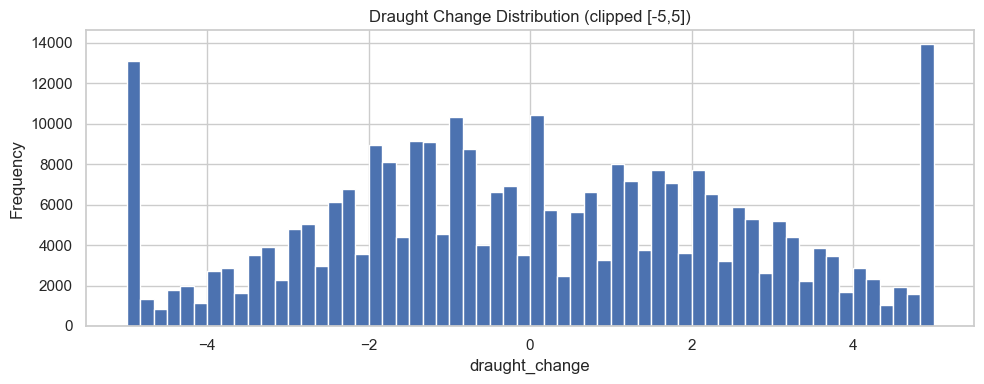

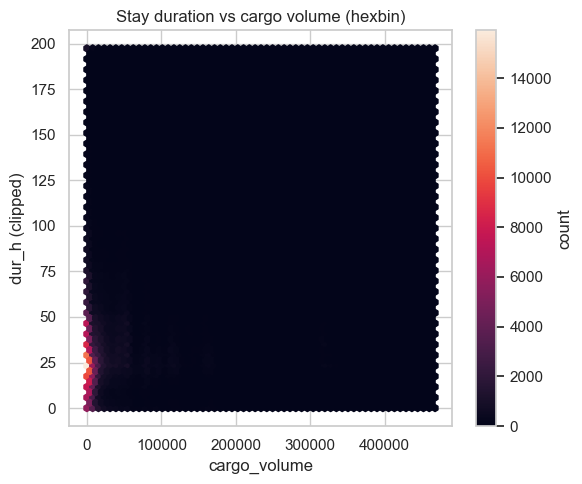

In [10]:
if "draught_change" in df_port_calls.columns:
    dc = df_port_calls.select(pl.col("draught_change")).to_pandas()
    dc["draught_change"] = dc["draught_change"].clip(-5, 5)
    dc["draught_change"].plot(kind="hist", bins=60)
    plt.title("Draught Change Distribution (clipped [-5,5])")
    plt.xlabel("draught_change")
    plt.tight_layout(); plt.show()

if "cargo_volume" in df_port_calls.columns and "dur_h" in df_port_calls.columns:
    sv = df_port_calls.select(["cargo_volume","dur_h"]).to_pandas()
    plt.figure(figsize=(6,5))
    plt.hexbin(sv["cargo_volume"], sv["dur_h"].clip(0, sv["dur_h"].quantile(0.995)), gridsize=60)
    plt.colorbar(label="count")
    plt.xlabel("cargo_volume"); plt.ylabel("dur_h (clipped)")
    plt.title("Stay duration vs cargo volume (hexbin)")
    plt.tight_layout(); plt.show()

**EDA trades**  
**EDA: Voyage duration & speed distribution (from trades)**

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/2511556629.py:92: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="vol_sum", index=VT_COL, columns="product_family_dom")


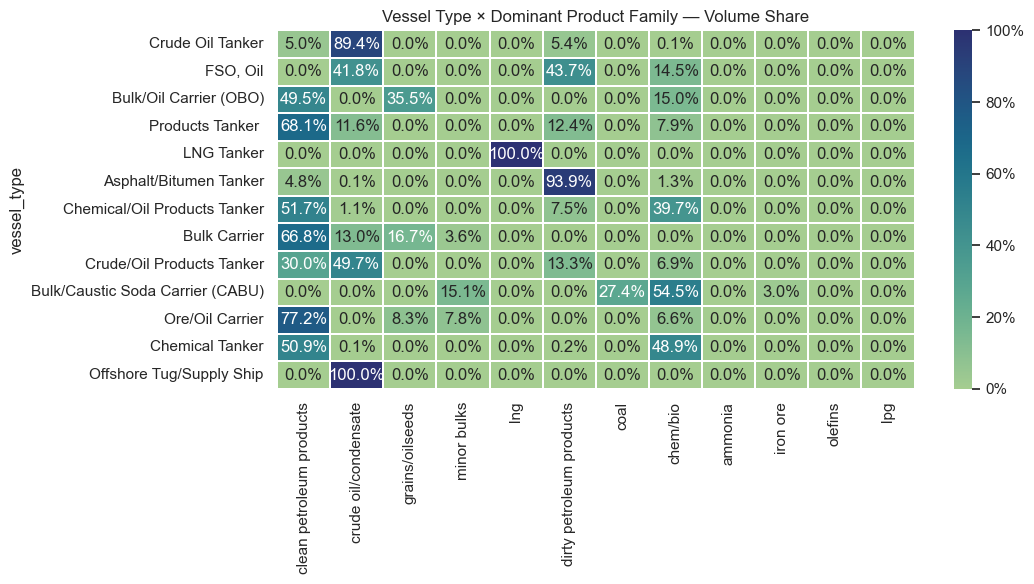

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/2511556629.py:106: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="vol_sum", index="dwt_bucket", columns="product_family_dom")


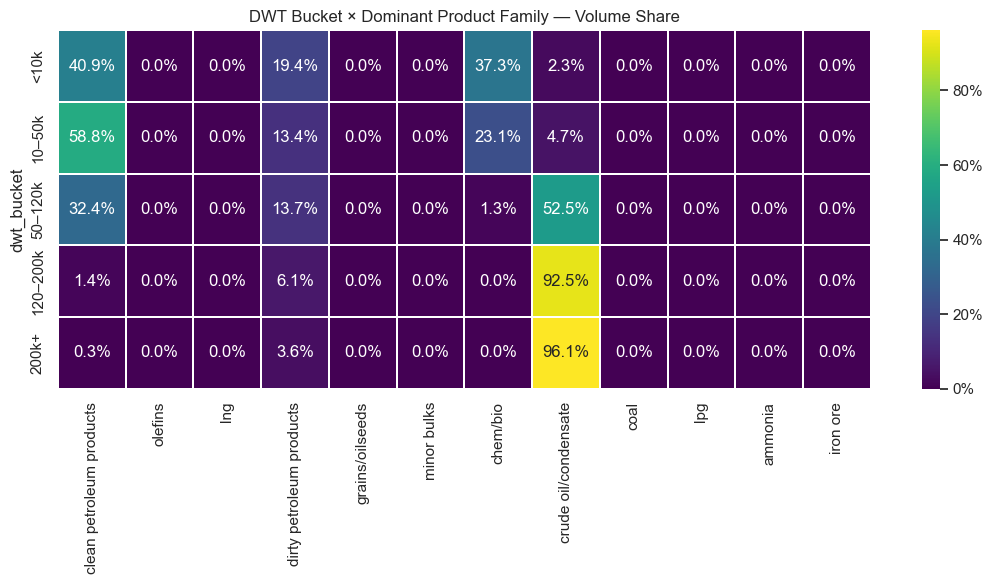

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/2511556629.py:131: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(values="vol_sum", index="vessel_type", columns="product_dom")


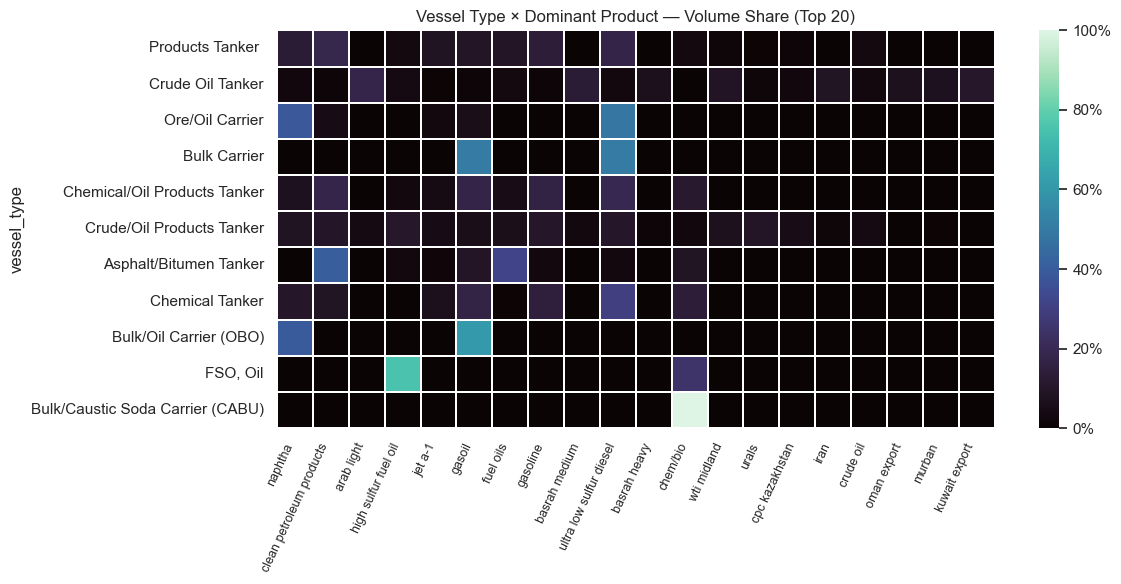

In [11]:
# =========================================
# × DWT × Product Family / Product 
# Vessel Type × DWT × Product Family / Product Heatmaps
# =========================================
if not all(c in df_trades.columns for c in ["port_call_origin_id", "product_family", "product", "traded_volume"]):
    print(" Missing required trade columns, skip cargo-product heatmaps.")
else:
    PF_COL, P_COL, VOL_COL = "product_family", "product", "traded_volume"

    # ---- 1)  origin  ----
    tr_pf_vol = (
        df_trades.filter(pl.col(VOL_COL).is_not_null())
        .group_by(["port_call_origin_id", PF_COL])
        .agg(pl.col(VOL_COL).sum().alias("vol_pf"))
    )
    tr_pf_dom = (
        tr_pf_vol.sort(["port_call_origin_id", "vol_pf"], descending=[False, True])
        .group_by("port_call_origin_id")
        .agg([
            pl.first(PF_COL).alias("product_family_dom"),
            pl.first("vol_pf").alias("product_family_dom_vol")
        ])
    )

    tr_p_vol = (
        df_trades.filter(pl.col(VOL_COL).is_not_null())
        .group_by(["port_call_origin_id", P_COL])
        .agg(pl.col(VOL_COL).sum().alias("vol_p"))
    )
    tr_p_dom = (
        tr_p_vol.sort(["port_call_origin_id", "vol_p"], descending=[False, True])
        .group_by("port_call_origin_id")
        .agg([
            pl.first(P_COL).alias("product_dom"),
            pl.first("vol_p").alias("product_dom_vol")
        ])
    )

    # ---- 2)  trades  ----
    pc_pf = df_port_calls.join(tr_pf_dom, left_on="id", right_on="port_call_origin_id", how="left")
    pc_pf = pc_pf.join(tr_p_dom, left_on="id", right_on="port_call_origin_id", how="left", suffix="_prod")
    
    # ---- 2.5)  ----
    if "vessel_id" in df_port_calls.columns:
        v_cols = [c for c in ["id","dead_weight","vessel_type","build_year"] if c in df_vessels.columns]
        pc_pf = pc_pf.join(
            df_vessels.select(v_cols).rename({"id": "vessel_id_ref"}),
            left_on="vessel_id", right_on="vessel_id_ref", how="left"
        )
    
    # ---- 3) DWT  ----
    if "dead_weight" in pc_pf.columns:
        pc_pf = pc_pf.with_columns(pl.col("dead_weight").cast(pl.Float64))
        pc_pf = pc_pf.with_columns(
            pl.when(pl.col("dead_weight").is_null()).then(pl.lit(None))
            .when(pl.col("dead_weight") < 10_000).then(pl.lit("<10k"))
            .when(pl.col("dead_weight") < 50_000).then(pl.lit("10–50k"))
            .when(pl.col("dead_weight") < 120_000).then(pl.lit("50–120k"))
            .when(pl.col("dead_weight") < 200_000).then(pl.lit("120–200k"))
            .otherwise(pl.lit("200k+"))
            .alias("dwt_bucket")
        )


    # ---- Helper ----
    def row_share(df: pd.DataFrame) -> pd.DataFrame:
        """行归一化：计算每行各列比例"""
        return df.div(df.sum(axis=1).replace(0, np.nan), axis=0)

    def heatmap_percent(df: pd.DataFrame, title: str, cmap="crest"):
        fig, ax = plt.subplots(figsize=(11, 6))
        sns.heatmap(
            df,
            cmap=cmap,
            annot=True,             
            fmt=".1%",               
            cbar_kws={"format": mtick.PercentFormatter(xmax=1.0)},
            linewidths=0.3,
            ax=ax
        )
        ax.set_title(title, fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # ---- 4)  × Product Family ----
    if "vessel_type" in df_vessels.columns:
        VT_COL = "vessel_type"
        ctab_vol = (
            pc_pf.filter(pl.col("product_family_dom").is_not_null())
            .group_by([VT_COL, "product_family_dom"])
            .agg(pl.col("product_family_dom_vol").sum().alias("vol_sum"))
            .pivot(values="vol_sum", index=VT_COL, columns="product_family_dom")
            .fill_null(0)
            .to_pandas()
            .set_index(VT_COL)
        )
        ctab_share = row_share(ctab_vol)
        heatmap_percent(ctab_share, "Vessel Type × Dominant Product Family — Volume Share", cmap="crest")

    # ---- 5) DWT × Product Family ----
    if "dwt_bucket" in pc_pf.columns:
        ctab_dwt_vol = (
            pc_pf.filter(pl.col("product_family_dom").is_not_null())
            .group_by(["dwt_bucket", "product_family_dom"])
            .agg(pl.col("product_family_dom_vol").sum().alias("vol_sum"))
            .pivot(values="vol_sum", index="dwt_bucket", columns="product_family_dom")
            .fill_null(0)
            .to_pandas()
            .set_index("dwt_bucket")
            .reindex(["<10k", "10–50k", "50–120k", "120–200k", "200k+"])
        )
        ctab_share = row_share(ctab_dwt_vol)
        heatmap_percent(ctab_share, "DWT Bucket × Dominant Product Family — Volume Share", cmap="viridis")

    # ---- 6) Product-level (Top-20) ----
    TOP_N_PRODUCTS = 20
    top_products = (
        pc_pf.filter(pl.col("product_dom").is_not_null())
        .group_by("product_dom")
        .agg(pl.col("product_dom_vol").sum().alias("total_vol"))
        .sort("total_vol", descending=True)
        .head(TOP_N_PRODUCTS)
        .to_pandas()["product_dom"]
        .tolist()
    )

    ctab_prod = (
        pc_pf.filter(pl.col("product_dom").is_in(top_products))
        .group_by(["vessel_type", "product_dom"])
        .agg(pl.col("product_dom_vol").sum().alias("vol_sum"))
        .pivot(values="vol_sum", index="vessel_type", columns="product_dom")
        .fill_null(0)
        .to_pandas()
        .set_index("vessel_type")
    )

    ctab_share = row_share(ctab_prod)
    plt.figure(figsize=(12, 6))
    sns.heatmap(ctab_share, cmap="mako",
                cbar_kws={"format": mtick.PercentFormatter(xmax=1.0)},
                linewidths=0.3)
    plt.title(f"Vessel Type × Dominant Product — Volume Share (Top {TOP_N_PRODUCTS})", fontsize=12)
    plt.xticks(rotation=65, ha="right", fontsize=9)
    plt.tight_layout()
    plt.show()

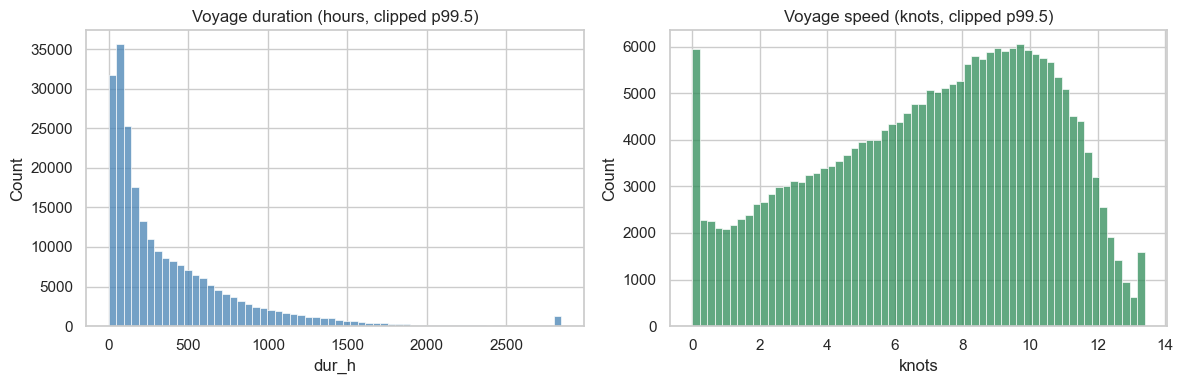

In [12]:
if set(["distance","start_date_time","end_date_time"]).issubset(set(df_trades.columns)):
    tr = (
        df_trades
        .select(["distance","start_date_time","end_date_time"])
        .with_columns([
            pl.col("start_date_time").cast(pl.Datetime).alias("t0"),
            pl.col("end_date_time").cast(pl.Datetime).alias("t1"),
            pl.col("distance").cast(pl.Float64).alias("dist_m"),
        ])
    )
    tr = tr.with_columns([
        ((pl.col("t1") - pl.col("t0")).dt.total_seconds()/3600.0).alias("dur_h")
    ])
    tr = tr.with_columns([
        (pl.col("dist_m") / (pl.col("dur_h") + 1e-9)).alias("m_per_h")
    ])

    pdf = tr.filter((pl.col("dur_h")>0) & pl.col("m_per_h").is_finite()).to_pandas()
    pdf["knots"] = (pdf["m_per_h"]/1000.0)/1.852  # m/h → km/h → knots

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(pdf["dur_h"].clip(upper=pdf["dur_h"].quantile(0.995)), bins=60, ax=ax[0], color="steelblue")
    ax[0].set_title("Voyage duration (hours, clipped p99.5)")

    sns.histplot(pdf["knots"].clip(upper=pdf["knots"].quantile(0.995)), bins=60, ax=ax[1], color="seagreen")
    ax[1].set_title("Voyage speed (knots, clipped p99.5)")
    plt.tight_layout(); plt.show()
else:
    print("trades lacks distance/start/end; skip voyage histogram.")

**STS**  
**Anomalies & events summary (neg/zero duration, STS/canal etc.)**

/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/287067797.py:15: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/287067797.py:15: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/wangwei/anaconda3/envs/kpler-ds/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/wangwei/anaconda3/envs/kpler-ds/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


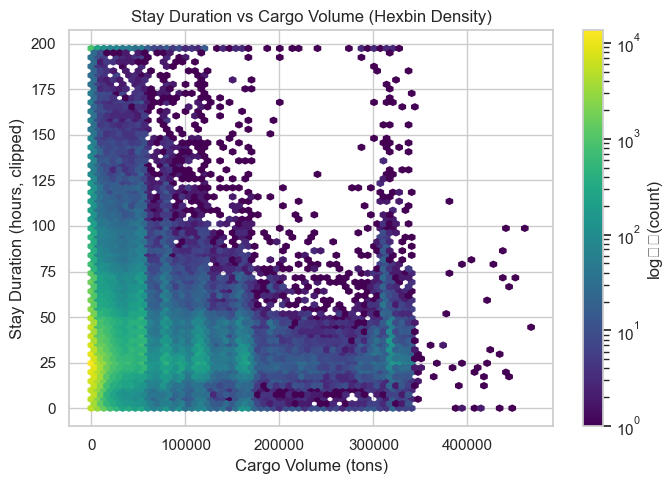

In [13]:
# ---- 3️⃣ Stay duration × cargo volume relationship ----
if "cargo_volume" in df_port_calls.columns and "dur_h" in df_port_calls.columns:
    sv = df_port_calls.select(["cargo_volume", "dur_h"]).to_pandas()
    sv["dur_h_clip"] = sv["dur_h"].clip(0, p995)  #  P99.5 
    plt.figure(figsize=(7, 5))
    hb = plt.hexbin(
        sv["cargo_volume"], sv["dur_h_clip"],
        gridsize=70, cmap="viridis", bins="log", mincnt=1
    )
    cb = plt.colorbar(hb)
    cb.set_label("log₁₀(count)")
    plt.xlabel("Cargo Volume (tons)")
    plt.ylabel("Stay Duration (hours, clipped)")
    plt.title("Stay Duration vs Cargo Volume (Hexbin Density)", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Missing cargo_volume or dur_h column — skipping hexbin plot.")

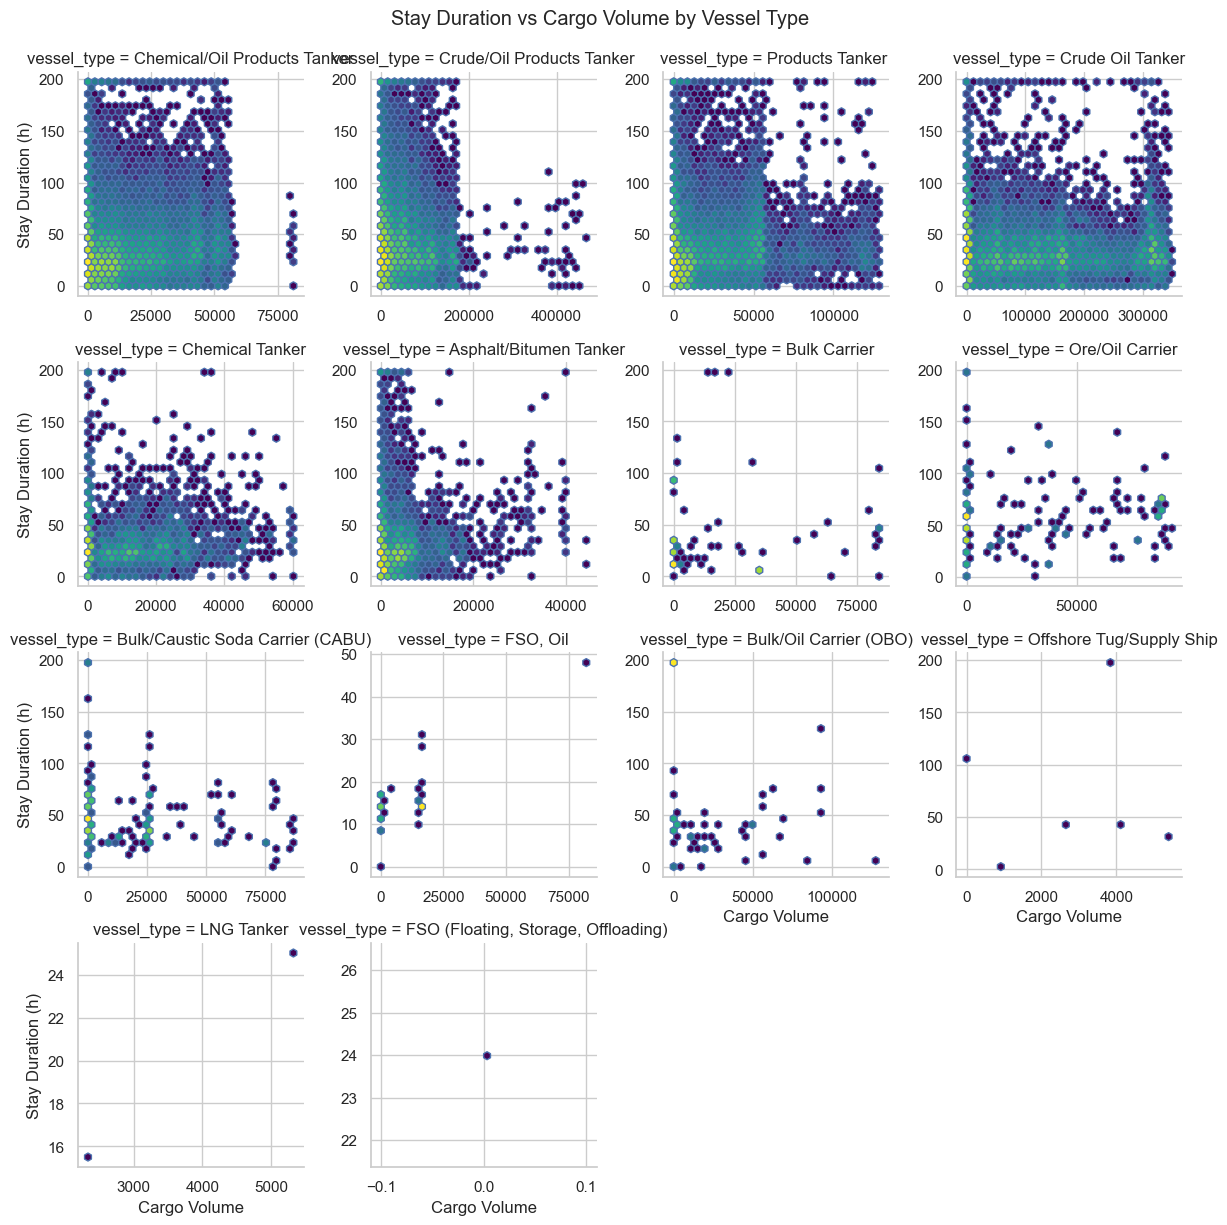

In [14]:
# ----  vessel_type  df_port_calls ----
# ---- If vessel_type is missing, join from df_vessels ----
if "vessel_type" not in df_port_calls.columns and "vessel_id" in df_port_calls.columns:
    v_cols = [c for c in ["id","vessel_type","dead_weight","build_year"] if c in df_vessels.columns]
    df_port_calls = df_port_calls.join(
        df_vessels.select(v_cols).rename({"id": "vessel_id_ref"}),
        left_on="vessel_id", right_on="vessel_id_ref", how="left"
    )

# ----  ----
VT_COL = "vessel_type" if "vessel_type" in df_port_calls.columns else None

# ----  cargo_volume vs dur_h hexbin ----
# ---- Plot stay duration vs cargo volume per vessel type ----
if VT_COL:
    p995 = df_port_calls.select(pl.col("dur_h").quantile(0.995)).item()
    sv = df_port_calls.select([VT_COL, "cargo_volume", "dur_h"]).drop_nulls().to_pandas()
    sv["dur_h_clip"] = sv["dur_h"].clip(0, p995)

    g = sns.FacetGrid(sv, col=VT_COL, col_wrap=4, height=3, sharex=False, sharey=False)
    g.map_dataframe(
        plt.hexbin,
        "cargo_volume", "dur_h_clip",
        gridsize=30, cmap="viridis", bins="log", mincnt=1
    )
    g.set_axis_labels("Cargo Volume", "Stay Duration (h)")
    g.fig.suptitle("Stay Duration vs Cargo Volume by Vessel Type", y=1.02)
    plt.show()
else:
    print(" Missing vessel_type — please join with vessels.csv first.")

In [15]:
#Adjustable: EDA sample  Interactive ports map (Folium heatmap + clustering)

# ---- Prepare geographic points ----
pts = (
    df_port_calls
    .select(["destination", "destination_latitude", "destination_longitude", "vessel_id"])
    .drop_nulls()
    .filter(
        (pl.col("destination_latitude").is_between(-90, 90)) &
        (pl.col("destination_longitude").is_between(-180, 180))
    )
    .to_pandas()
)

print(f"✅ Loaded {len(pts):,} valid port call points for mapping.")

# ---- Create base map ----
center_lat, center_lon = (
    pts["destination_latitude"].mean(),
    pts["destination_longitude"].mean(),
)
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=2,
    tiles="CartoDB positron"
)

# ---- Add heatmap layer (for dense port areas) ----
HeatMap(
    data=pts[["destination_latitude", "destination_longitude"]].values,
    radius=7, blur=5, min_opacity=0.2, max_zoom=6
).add_to(m)

# ---- Add marker cluster (sample subset for speed) ----
SAMPLE_SIZE = min(5000, len(pts))
mc = MarkerCluster(name=f"Sampled {SAMPLE_SIZE:,} ports").add_to(m)

sample_pts = pts.sample(n=SAMPLE_SIZE, random_state=42)
for _, r in sample_pts.iterrows():
    folium.CircleMarker(
        [r["destination_latitude"], r["destination_longitude"]],
        radius=2,
        color="#3388ff",
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(f"<b>{r['destination']}</b><br>vessel ID: {r['vessel_id']}", max_width=150),
        tooltip=f"{r['destination']}"
    ).add_to(mc)

# ---- 5️⃣  ----
# ---- Save map to processed folder ----
out_map = PROCESSED_DIR / "figures"
out_map.mkdir(parents=True, exist_ok=True)
map_path = out_map / "ports_map.html"
m.save(map_path)

print(f" Map saved to: {map_path.resolve()}")
print(" Double-click the HTML file to open it in your browser.")

✅ Loaded 346,232 valid port call points for mapping.
 Map saved to: /Users/wangwei/Documents/Folders/工作/Kpler/data/processed/figures/ports_map.html
 Double-click the HTML file to open it in your browser.


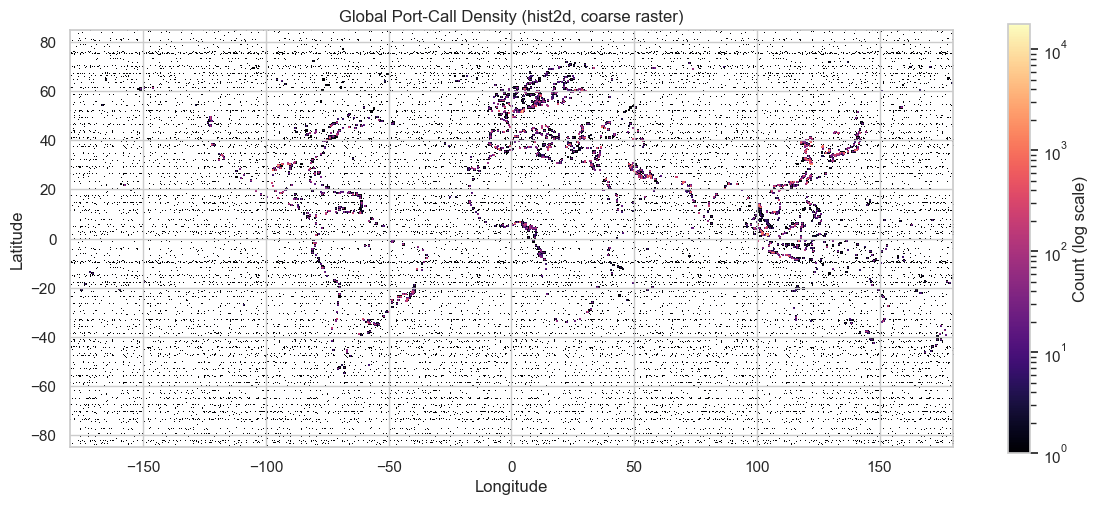

In [16]:
#Adjustable: number of bins (smaller is faster/coarser)
if LAT_COL and LON_COL:
    geo = (
        df_port_calls
        .select([pl.col(LAT_COL).alias("lat"), pl.col(LON_COL).alias("lon")])
        .drop_nulls()
        .filter(
            pl.col("lat").is_between(-85, 85) &
            pl.col("lon").is_between(-180, 180)
        )
        .to_pandas()
    )

    H, xedges, yedges = np.histogram2d(
        geo["lon"].values, geo["lat"].values,
        bins=[720, 360],                 # : (lon_bins, lat_bins)
        range=[[-180, 180], [-85, 85]]
    )
    plt.figure(figsize=(12, 5))
    plt.imshow(
        H.T, origin="lower",
        extent=[-180, 180, -85, 85],
        cmap="magma", norm=LogNorm(vmin=max(1, H.min()), vmax=H.max())
    )
    plt.colorbar(label="Count (log scale)")
    plt.title("Global Port-Call Density (hist2d, coarse raster)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()
else:
    print(" No LAT/LON columns detected.")

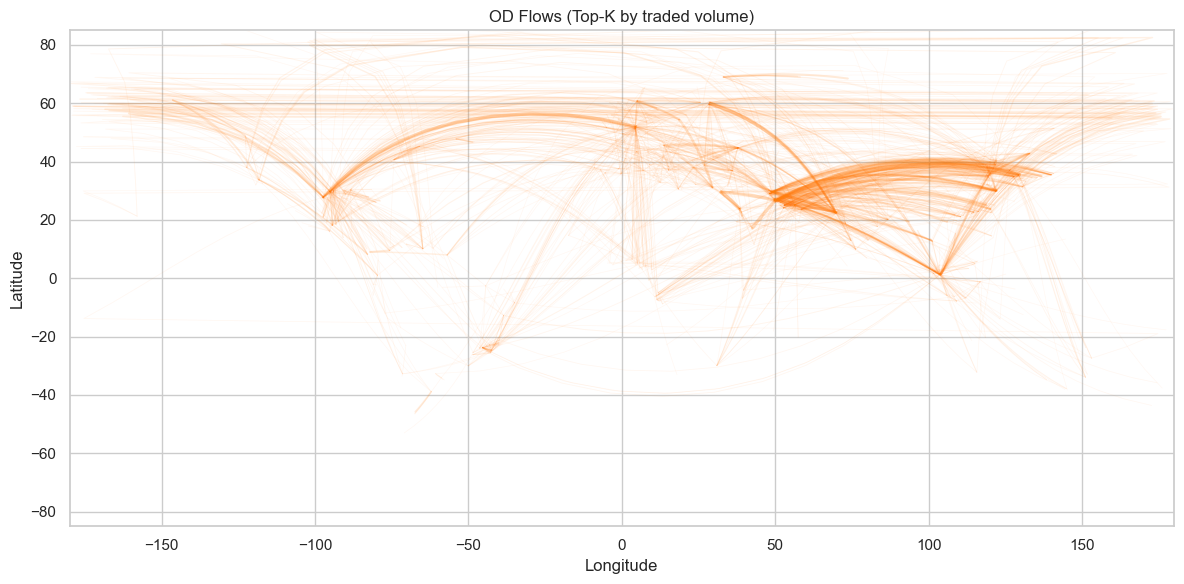

In [17]:
# Adjustable: Top-K flows to plot, samples per arc, and linewidth scaling
TOP_K_FLOWS = 2000
ARC_SAMPLES = 12

# --- 1) Prepare data for Origin-Destination (OD) flows ---
# Create a lookup table for port coordinates from the main port calls table

pc_xy = df_port_calls.select([
    pl.col("id").alias("pc_id"),
    pl.col("destination").alias("port"),
    pl.col("destination_latitude").alias("lat"),
    pl.col("destination_longitude").alias("lon"),
]).drop_nulls()

# Construct the main 'edges' DataFrame representing trade flows
edges = (
    df_trades
    .select(["port_call_origin_id","port_call_destination_id","traded_volume"])
    .join(pc_xy.rename({"pc_id":"port_call_origin_id","port":"o_port","lat":"olat","lon":"olon"}), on="port_call_origin_id", how="inner")
    .join(pc_xy.rename({"pc_id":"port_call_destination_id","port":"d_port","lat":"dlat","lon":"dlon"}), on="port_call_destination_id", how="inner")
    .group_by(["o_port","d_port","olat","olon","dlat","dlon"])
    .agg(pl.col("traded_volume").sum().alias("vol"))
    .filter(pl.col("vol")>0)
    .sort("vol", descending=True)
    .head(2000)                                  # : Top-K
    .to_pandas()
)

# --- 2) Define function for spherical interpolation (to draw great-circle arcs) ---
def slerp_lonlat(a, b, n=12):
    # a,b: [lat, lon] in degrees; return N points [[lon,lat],...]
    lat1, lon1, lat2, lon2 = np.radians([a[0], a[1], b[0], b[1]])
    d = 2*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2))
    if d == 0: return np.array([[a[1], a[0]],[b[1], b[0]]])
    ts = np.linspace(0,1,n)
    A = np.sin((1-ts)*d)/np.sin(d); B = np.sin(ts*d)/np.sin(d)
    x = A*np.cos(lat1)*np.cos(lon1) + B*np.cos(lat2)*np.cos(lon2)
    y = A*np.cos(lat1)*np.sin(lon1) + B*np.cos(lat2)*np.sin(lon2)
    z = A*np.sin(lat1)             + B*np.sin(lat2)
    lat = np.degrees(np.arctan2(z, np.sqrt(x*x+y*y)))
    lon = np.degrees(np.arctan2(y, x))
    return np.c_[lon, lat]

# --- 3) Set up the base map plot ---
plt.figure(figsize=(12,6))
plt.xlim(-180,180); plt.ylim(-85,85)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("OD Flows (Top-K by traded volume)")

# --- 4) Dynamically scale line width and alpha based on trade volume ---
# This makes high-volume routes appear thicker and more opaque
v = edges["vol"].values.astype(float)
lw = 0.5 + 3.0 * (v - v.min()) / (v.max() - v.min() + 1e-9)
alpha = 0.05 + 0.35 * (v - v.min()) / (v.max() - v.min() + 1e-9)

# --- 5) Iterate through each trade route and plot its great-circle path ---
for i, r in edges.iterrows():
    path = slerp_lonlat([r["olat"], r["olon"]], [r["dlat"], r["dlon"]], n=12)
    plt.plot(path[:,0], path[:,1], color="tab:orange", lw=lw[i], alpha=alpha[i])

plt.tight_layout(); plt.show()

In [18]:
#Adjustable: top-N busiest ports to display
TOP_N = 20

# --- Auto-detect relevant columns ---
# --- 1) Global counts ---
n_calls  = df_port_calls.height
n_ports  = (df_port_calls.select(pl.col(PORT_COL).n_unique()).item() if PORT_COL else np.nan)
n_vessel = (df_port_calls.select(pl.col("vessel_id").n_unique()).item() if "vessel_id" in df_port_calls.columns else np.nan)

# --- 2) Top-N busiest ports + long-tail share ---
if PORT_COL:
    top_ports_df = (
        df_port_calls.group_by(PORT_COL).len()
        .sort("len", descending=True).head(TOP_N)
        .rename({"len":"calls"})
        .to_pandas()
    )
    top_calls   = int(top_ports_df["calls"].sum())
    head_share  = top_calls / n_calls
    tail_share  = 1 - head_share
else:
    top_ports_df = pd.DataFrame(columns=["destination","calls"])
    head_share, tail_share = np.nan, np.nan

# --- 3a) Port-level coverage gap (set of distinct ports) ---
if PORT_COL and all(c in df_trades.columns for c in ["port_call_origin_id","port_call_destination_id"]):
    #  port_calls 
    ports_pc = set(
        df_port_calls.select(pl.col(PORT_COL)).drop_nulls().unique().to_series().to_list()
    )

    #  port_call id  trades 
    id_to_port = df_port_calls.select(["id", PORT_COL]).to_dict(as_series=False)
    id_map = dict(zip(id_to_port["id"], id_to_port[PORT_COL]))

    trade_ports = set()
    for col in ["port_call_origin_id", "port_call_destination_id"]:
        trade_ports.update(
            [id_map.get(x) for x in df_trades[col].drop_nulls().to_list() if x in id_map]
        )
    trade_ports = {p for p in trade_ports if p is not None}

    only_in_pc = ports_pc - trade_ports
    only_in_tr = trade_ports - ports_pc

    n_only_pc  = len(only_in_pc)
    n_only_tr  = len(only_in_tr)
    share_only_pc = n_only_pc / len(ports_pc) if len(ports_pc) else np.nan
    share_only_tr = n_only_tr / len(trade_ports) if len(trade_ports) else np.nan
else:
    n_only_pc = n_only_tr = share_only_pc = share_only_tr = np.nan
    only_in_pc, only_in_tr = set(), set()

# --- 3b) Row-level coverage gap (rows: how many port_call rows are not referenced by trades) ---
if all(c in df_trades.columns for c in ["port_call_origin_id","port_call_destination_id"]):
    origin_ids = set(df_trades.select(pl.col("port_call_origin_id")).to_series().drop_nulls().to_list())
    dest_ids   = set(df_trades.select(pl.col("port_call_destination_id")).to_series().drop_nulls().to_list())
    trade_ids_all = origin_ids | dest_ids

    mask_unlinked = ~pl.col("id").is_in(list(trade_ids_all))
    rows_not_in_trades = df_port_calls.filter(mask_unlinked).height
    row_gap_pct = rows_not_in_trades / n_calls if n_calls else float("nan")

    #  cargo_volume>0 
    #Optional: among unlinked rows, how many have cargo_volume>0 (if the column exists)
    if "cargo_volume" in df_port_calls.columns:
        rows_not_in_trades_with_cargo = df_port_calls.filter(
            mask_unlinked & (pl.col("cargo_volume") > 0)
        ).height
        rows_not_in_trades_with_cargo_pct = (
            rows_not_in_trades_with_cargo / rows_not_in_trades if rows_not_in_trades else np.nan
        )
    else:
        rows_not_in_trades_with_cargo = None
        rows_not_in_trades_with_cargo_pct = np.nan
else:
    rows_not_in_trades = np.nan
    row_gap_pct = np.nan
    rows_not_in_trades_with_cargo = None
    rows_not_in_trades_with_cargo_pct = np.nan

# --- 4) Markdown summary ---
md = f"""
### Dataset overview / 
- **Port calls**: {n_calls:,}  
- **Distinct destinations**: {n_ports:,}  
- **Distinct vessels**: {n_vessel:,}  

**Busiest ports (Top {TOP_N})**  
Top-{TOP_N} share of total: **{head_share:,.1%}**, long-tail share: **{tail_share:,.1%}**

**Coverage comparison**  
- *Port-level* — ports only in `port_calls`: **{n_only_pc:,}** (**{share_only_pc:.1%}** of distinct ports in port_calls)  
- *Port-level* — ports only in `trades`: **{n_only_tr:,}** (**{share_only_tr:.1%}** of distinct ports in trades)  

- *Row-level* — port_call rows **not referenced by any trade**: **{rows_not_in_trades:,} / {n_calls:,} = {row_gap_pct:.2%}**
{"- *Row-level* — among those, cargo_volume>0: **{:,} ({:.2%})**".format(rows_not_in_trades_with_cargo, rows_not_in_trades_with_cargo_pct) if rows_not_in_trades_with_cargo is not None else ""}
"""
display(Markdown(md))

# --- 5) Tables & examples ---
display(Markdown("#### Top busiest ports"))
display(top_ports_df.head(TOP_N))

if n_only_pc or n_only_tr:
    display(Markdown("#### Examples of coverage differences / "))
    print("Ports only in port_calls (前10):", list(sorted(only_in_pc))[:10])
    print("Ports only in trades (前10):",   list(sorted(only_in_tr))[:10])


### Dataset overview / 
- **Port calls**: 347,250  
- **Distinct destinations**: 2,063  
- **Distinct vessels**: 8,890  

**Busiest ports (Top 20)**  
Top-20 share of total: **20.5%**, long-tail share: **79.5%**

**Coverage comparison**  
- *Port-level* — ports only in `port_calls`: **52** (**2.5%** of distinct ports in port_calls)  
- *Port-level* — ports only in `trades`: **0** (**0.0%** of distinct ports in trades)  

- *Row-level* — port_call rows **not referenced by any trade**: **21,217 / 347,250 = 6.11%**
- *Row-level* — among those, cargo_volume>0: **13,878 (65.41%)**


#### Top busiest ports

,destination,calls
0,Singapore,12640
1,Rotterdam,8429
2,Ulsan,6114
3,Antwerp,5371
4,Houston,4825
5,Pelepas Light.,3199
6,Yeosu,2691
7,Zhoushan,2419
8,Lome Light.,2407
9,Daesan,2364


#### Examples of coverage differences / 

Ports only in port_calls (前10): ['Afrikahaven2 Light.', 'Al Mukha', 'Asimar Shipyard', 'Avacha Bay Light.', 'Baia de Todos os Santos Light', 'Bandar-e-Jask', 'Beilun Light.', 'Big Stone Light.', 'Cape Dorset', 'Colombo Light.']
Ports only in trades (前10): []


In [19]:
#Adjustable: column names
PORT_COL = "destination"  # destination name in port_calls

# ==== Row-level coverage: % of port_call rows NOT referenced by any trade (as origin or destination) ====
origin_ids = set(df_trades.select(pl.col("port_call_origin_id")).to_series().drop_nulls().to_list())
dest_ids   = set(df_trades.select(pl.col("port_call_destination_id")).to_series().drop_nulls().to_list())
trade_ids_all = origin_ids | dest_ids

rows_not_in_trades = df_port_calls.filter(~pl.col("id").is_in(list(trade_ids_all))).height
row_gap_pct = rows_not_in_trades / df_port_calls.height if df_port_calls.height else float("nan")

# ==== Port-level coverage: destinations only in port_calls vs only in trades ====
# union of origin & destination names resolved via join to port_calls
tr_ports_names = (
    df_trades
    .select(["port_call_origin_id","port_call_destination_id"])
    .melt(variable_name="kind", value_name="pc_id")
    .drop_nulls()
    .join(df_port_calls.select(["id", PORT_COL]), left_on="pc_id", right_on="id", how="left")
    .select(pl.col(PORT_COL))
    .drop_nulls()
    .unique()
    .to_series()
    .to_list()
)
ports_in_trades = set(tr_ports_names)

ports_in_pc = set(
    df_port_calls.select(pl.col(PORT_COL))
    .drop_nulls()
    .unique()
    .to_series()
    .to_list()
)

only_pc = ports_in_pc - ports_in_trades
only_tr = ports_in_trades - ports_in_pc

port_only_pc_pct = len(only_pc) / len(ports_in_pc) if ports_in_pc else float("nan")
port_only_tr_pct = len(only_tr) / len(ports_in_trades) if ports_in_trades else float("nan")

print("Row-level gap (port_call rows not in any trade): "
      f"{rows_not_in_trades:,} / {df_port_calls.height:,} = {row_gap_pct:.2%}")
print("Port-level gap: only-in-port_calls = "
      f"{len(only_pc):,} ({port_only_pc_pct:.2%} of port_calls' distinct destinations); "
      f"only-in-trades = {len(only_tr):,} ({port_only_tr_pct:.2%} of trades' distinct destinations)")

# ==== Multiplicity: how many distinct trade destinations per origin ====
multi = (
    df_trades
    .group_by("port_call_origin_id")
    .agg(pl.col("port_call_destination_id").n_unique().alias("n_dests"))
    .group_by("n_dests")
    .len()
    .sort("n_dests")
    .rename({"len":"count"})
)
print("\nDistribution of #distinct trade destinations per origin:")
print(multi)

Row-level gap (port_call rows not in any trade): 21,217 / 347,250 = 6.11%
Port-level gap: only-in-port_calls = 52 (2.52% of port_calls' distinct destinations); only-in-trades = 0 (0.00% of trades' distinct destinations)

Distribution of #distinct trade destinations per origin:
shape: (14, 2)
┌─────────┬────────┐
│ n_dests ┆ count  │
│ ---     ┆ ---    │
│ u32     ┆ u32    │
╞═════════╪════════╡
│ 1       ┆ 122392 │
│ 2       ┆ 29243  │
│ 3       ┆ 7577   │
│ 4       ┆ 2339   │
│ 5       ┆ 719    │
│ …       ┆ …      │
│ 10      ┆ 73     │
│ 11      ┆ 5      │
│ 12      ┆ 3      │
│ 13      ┆ 2      │
│ 15      ┆ 1      │
└─────────┴────────┘


/var/folders/ck/_xz08r3x10b7ftmpmxls284m0000gn/T/ipykernel_76918/1274887795.py:17: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(variable_name="kind", value_name="pc_id")


In [20]:
only_in_pc

{'Afrikahaven2 Light.',
 'Al Mukha',
 'Asimar Shipyard',
 'Avacha Bay Light.',
 'Baia de Todos os Santos Light',
 'Bandar-e-Jask',
 'Beilun Light.',
 'Big Stone Light.',
 'Cape Dorset',
 'Colombo Light.',
 'Cristobal Light.',
 'Drift River',
 'Frederikshavn Light.',
 'Freeport Light.',
 'Gdynia Light.',
 'Guayaquil Light.',
 'Hillsborough',
 'KM171 Light.',
 'Kharg Island Light.',
 'Khasab Light.',
 'Kutch Light.',
 'Louisiana',
 'Luanda Light.',
 'Mokpo New Port',
 'Mumbai Light.',
 'Nagasaki Light.',
 'Nanjing Light.',
 'North East Atlantic Ocean',
 'Port of Turkmenbashi',
 'Red Sea',
 "Saint George's",
 'Scapa Flow Light.',
 'Shigei',
 'Southwold Light.',
 'Suez Canal',
 'Tan Thuan Dong Shipyard',
 'Tema Light.',
 'Tiksi',
 'Trinidad Light.',
 'Tuzla',
 'Twon-Brass',
 'United States',
 'Ust Luga STS Light.',
 'Vlissingen Light.',
 'WCL Light.',
 'Western Petroleum B Anchorage',
 'White Island',
 'Xiazhimen Light.',
 'Yalova',
 'Yanbu Light.',
 'Yinyang',
 'Yokohama Light.'}

In [21]:
#Adjustable: keep only trades with positive distance/valid times
need_cols = {"port_call_origin_id","distance","product_family","start_date_time","end_date_time"}
assert need_cols.issubset(set(df_trades.columns)), "trades.csv 缺少必要列 / required columns missing in trades"

# --- 1) Join origin port_call -> vessel_id -> vessel_type ---
tr = df_trades.select(["port_call_origin_id","distance","product_family","start_date_time","end_date_time"]).clone()
pc_min = df_port_calls.select(["id","vessel_id"])
vs_min = df_vessels.select(["id","vessel_type"])

tr = (
    tr.join(pc_min, left_on="port_call_origin_id", right_on="id", how="left")
      .join(vs_min, left_on="vessel_id", right_on="id", how="left", suffix="_v")
)
# --- 2) Filter anomalies (non-positive distance/duration) and convert to km ---
tr = tr.with_columns([
    (pl.col("distance").cast(pl.Float64)).alias("distance_m"),
    pl.col("start_date_time").cast(pl.Datetime).alias("t0"),
    pl.col("end_date_time").cast(pl.Datetime).alias("t1"),
]).with_columns([
    ((pl.col("t1") - pl.col("t0")).dt.total_seconds() / 3600.0).alias("dur_h"),
    (pl.col("distance_m") / 1000.0).alias("distance_km"),
]).filter(
    (pl.col("distance_km") > 0) & (pl.col("dur_h") > 0)
)

# --- 3) By vessel_type: count & mean distance ---
vt_tbl = (
    tr.group_by("vessel_type")
      .agg([
          pl.len().alias("trades"),
          pl.col("distance_km").mean().alias("avg_dist_km"),
      ])
      .sort("avg_dist_km", descending=True)
      .to_pandas()
)
display(Markdown("#### Voyage by vessel type /  × "))
vt_tbl.head(12)

# --- 4) By product_family: count & mean distance ---
pf_tbl = (
    tr.group_by("product_family")
      .agg([
          pl.len().alias("trades"),
          pl.col("distance_km").mean().alias("avg_dist_km"),
      ])
      .sort(["trades","avg_dist_km"], descending=[True, True])
      .to_pandas()
)

pf_tbl.head(12)
# --- 5) Key takeaways (auto text) ---
def topn_names(df, col, n=3):
    return ", ".join([str(x) for x in df[col].head(n).tolist()])

md2 = f"""
**Takeaways**  
- Longest avg distance vessel types: **{topn_names(vt_tbl, 'vessel_type', 3)}**  
- Most frequent product families: **{topn_names(pf_tbl, 'product_family', 3)}**  
- Longest avg distance product families: **{topn_names(pf_tbl.sort_values('avg_dist_km', ascending=False), 'product_family', 3)}**  
"""
display(Markdown(md2))

#### Voyage by vessel type /  × 


**Takeaways**  
- Longest avg distance vessel types: **Ore/Oil Carrier, None, Bulk/Oil Carrier (OBO)**  
- Most frequent product families: **clean petroleum products, chem/bio, dirty petroleum products**  
- Longest avg distance product families: **grains/oilseeds, crude oil/condensate, coal**  


In [22]:
# --- A) Duration & speed anomalies in trades ---
tr_s = (
    df_trades.select(["distance","start_date_time","end_date_time"])
             .with_columns([
                 pl.col("start_date_time").cast(pl.Datetime).alias("t0"),
                 pl.col("end_date_time").cast(pl.Datetime).alias("t1"),
                 pl.col("distance").cast(pl.Float64).alias("dist_m"),
             ])
             .with_columns([
                 ((pl.col("t1") - pl.col("t0")).dt.total_seconds() / 3600.0).alias("dur_h")
             ])
             .with_columns([
                 (pl.col("dist_m") / (pl.col("dur_h") + 1e-9)).alias("m_per_h")
             ])
)

neg_dur = tr_s.filter(pl.col("dur_h") < 0).height
zero_dur = tr_s.filter(pl.col("dur_h") == 0).height
inf_spd = tr_s.filter(~pl.col("m_per_h").is_finite()).height
p95_spd = tr_s.filter(pl.col("m_per_h").is_finite()).select(pl.col("m_per_h").quantile(0.95)).item()

# --- B) Port calls not linked to trades (and cargo>0 among them) ---
origin_ids = df_trades.select(pl.col("port_call_origin_id")).to_series().to_list()
dest_ids   = df_trades.select(pl.col("port_call_destination_id")).to_series().to_list()
trade_ids  = set([x for x in origin_ids + dest_ids if x is not None])

no_trade_calls = df_port_calls.filter(~pl.col("id").is_in(list(trade_ids)))
no_trade_cnt   = no_trade_calls.height
with_cargo_cnt = (no_trade_calls.filter(pl.col("cargo_volume") > 0).height
                  if "cargo_volume" in no_trade_calls.columns else np.nan)

# --- C) STS & canal keywords ---
if PORT_COL:
    sts_cnt   = df_port_calls.filter(pl.col(PORT_COL).str.contains("(?i)light|STS")).height
    canal_cnt = df_port_calls.filter(pl.col(PORT_COL).str.contains("(?i)suez|panama|canal")).height
else:
    sts_cnt, canal_cnt = np.nan, np.nan

# --- D) Markdown bullets + small stats table ---
md = f"""
### Anomalies & special events
- **Trades negative duration**: {neg_dur:,}  
- **Trades zero duration**: {zero_dur:,}  
- **Inf/NaN speed trades**: {inf_spd:,}  
- **95th percentile speed (m/h)**: {p95_spd:,.0f}

- **Port calls not in trades**: {no_trade_cnt:,}  
- **Among them cargo_volume>0**: {with_cargo_cnt:,}

- **STS-like (\"Light.\"/STS) calls**: {sts_cnt:,}  
- **Canal-related calls (Suez/Panama/Canal)**: {canal_cnt:,}  
"""
display(Markdown(md))

#Small table (easy to copy)
pd.DataFrame({
    "metric":[
        "trades_neg_duration","trades_zero_duration","trades_inf_or_nan_speed","speed_p95_m_per_h",
        "port_calls_not_in_trades","no_trade_calls_with_cargo",
        "sts_like_calls","canal_related_calls"
    ],
    "value":[neg_dur, zero_dur, inf_spd, int(p95_spd), no_trade_cnt, with_cargo_cnt, sts_cnt, canal_cnt]
})


### Anomalies & special events
- **Trades negative duration**: 13  
- **Trades zero duration**: 392  
- **Inf/NaN speed trades**: 0  
- **95th percentile speed (m/h)**: 22,004

- **Port calls not in trades**: 21,217  
- **Among them cargo_volume>0**: 13,878

- **STS-like ("Light."/STS) calls**: 22,348  
- **Canal-related calls (Suez/Panama/Canal)**: 433  


,metric,value
0,trades_neg_duration,13
1,trades_zero_duration,392
2,trades_inf_or_nan_speed,0
3,speed_p95_m_per_h,22004
4,port_calls_not_in_trades,21217
5,no_trade_calls_with_cargo,13878
6,sts_like_calls,22348
7,canal_related_calls,433


In [23]:
#Adjustable: output path
REPORT_PATH = PROCESSED_DIR / "insights_report.md"

lines = []
lines.append("# Insights summary / \n")

# 1) Overview
lines.append("## Dataset overview / \n")
lines.append(f"- Port calls: {n_calls:,}\n- Distinct destinations: {n_ports:,}\n- Distinct vessels: {n_vessel:,}\n")
lines.append(f"- Top-{TOP_N} busiest ports share: {head_share:,.1%}; long tail: {tail_share:,.1%}\n")

# 2) Voyage patterns
lines.append("\n## Voyage patterns / \n")
lines.append("### Vessel type × distance (top 10)\n")
lines.append(vt_tbl.head(10).to_markdown(index=False))
lines.append("\n\n### Product family × distance (top 10)\n")
lines.append(pf_tbl.head(10).to_markdown(index=False))

# 3) Anomalies & events
lines.append("\n## Anomalies & special events / \n")
lines.append(f"- Trades negative duration: {neg_dur:,}\n- Trades zero duration: {zero_dur:,}\n- Inf/NaN speeds: {inf_spd:,}\n- Speed p95 (m/h): {p95_spd:,.0f}\n")
lines.append(f"- Port calls not linked to trades: {no_trade_cnt:,}; with cargo>0: {with_cargo_cnt:,}\n")
lines.append(f"- STS-like calls: {sts_cnt:,}; canal-related: {canal_cnt:,}\n")

Path(REPORT_PATH).write_text("\n".join(lines), encoding="utf-8")
print("Report saved to:", REPORT_PATH)


Report saved to: /Users/wangwei/Documents/Folders/工作/Kpler/data/processed/insights_report.md


In [24]:
#Adjustable: Trade reconstruction (greedy matching using load/discharge flags)
inferred_tr = infer_trades_from_port_calls(df_port_calls)
summary = calibrate_with_official(inferred_tr, df_trades)
print(summary)

#Adjustable: Persist inferred trades for reuse
inferred_path = PROCESSED_DIR / 'inferred_trades.parquet'
inferred_tr.write_parquet(inferred_path)
print('Saved:', inferred_path)

shape: (2, 2)
┌─────────────┬───────┐
│ metric      ┆ value │
│ ---         ┆ ---   │
│ str         ┆ i64   │
╞═════════════╪═══════╡
│ pair_exact  ┆ 20178 │
│ origin_only ┆ 55533 │
└─────────────┴───────┘
Saved: /Users/wangwei/Documents/Folders/工作/Kpler/data/processed/inferred_trades.parquet


In [25]:
PORT_COL = "destination" if "destination" in df_port_calls.columns else None

# --- trades  ---
if set(["distance","start_date_time","end_date_time"]).issubset(set(df_trades.columns)):
    tr_s = (
        df_trades
        .select(["distance","start_date_time","end_date_time"])
        .with_columns([
            pl.col("start_date_time").cast(pl.Datetime).alias("t0"),
            pl.col("end_date_time").cast(pl.Datetime).alias("t1"),
            pl.col("distance").cast(pl.Float64).alias("dist_m"),
        ])
    )
    tr_s = tr_s.with_columns([
        ((pl.col("t1") - pl.col("t0")).dt.total_seconds() / 3600.0).alias("dur_h")
    ])
    #  dur_h 
    tr_s = tr_s.with_columns([
        (pl.col("dist_m") / (pl.col("dur_h") + 1e-9)).alias("m_per_h")
    ])

    neg_dur = tr_s.filter(pl.col("dur_h") < 0).height
    zero_dur = tr_s.filter(pl.col("dur_h") == 0).height
    inf_spd = tr_s.filter(~pl.col("m_per_h").is_finite()).height
else:
    neg_dur = zero_dur = inf_spd = np.nan

# --- STS / Canal ---
if PORT_COL:
    sts_cnt = df_port_calls.filter(pl.col(PORT_COL).str.contains("(?i)light|STS")).height
    canal_cnt = df_port_calls.filter(pl.col(PORT_COL).str.contains("(?i)suez|panama|canal")).height
else:
    sts_cnt = canal_cnt = np.nan

print(dict(
    neg_dur=neg_dur,
    zero_dur=zero_dur,
    inf_speed=inf_spd,
    sts_like=sts_cnt,
    canal_like=canal_cnt
))

{'neg_dur': 13, 'zero_dur': 392, 'inf_speed': 0, 'sts_like': 22348, 'canal_like': 433}


** Task‑A **  
**Build Task‑A samples and save (keep downstream‑useful columns)**

In [26]:
samples = build_samples_taskA(df_port_calls, df_trades, df_vessels)
print("samples_taskA:", samples.shape)
print(samples.head(3))

samples_taskA: (338360, 15)
shape: (3, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ sample_po ┆ vessel_id ┆ destinati ┆ destinati ┆ … ┆ next_call ┆ prev_dist ┆ last_leg_ ┆ product_ │
│ rt_call_i ┆ ---       ┆ on        ┆ on_latitu ┆   ┆ _name     ┆ _km       ┆ knots_est ┆ family_d │
│ d         ┆ i64       ┆ ---       ┆ de        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ om       │
│ ---       ┆           ┆ str       ┆ ---       ┆   ┆ str       ┆ f64       ┆ f64       ┆ ---      │
│ i64       ┆           ┆           ┆ f64       ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 367206086 ┆ 56709     ┆ Texas     ┆ 29.370731 ┆ … ┆ Texas     ┆ null      ┆ null      ┆ chem/bio │
│           ┆           ┆ City      ┆           ┆   ┆ City      ┆           ┆           ┆          │
│ 367333127 ┆ 56709     ┆ Texas     ┆ 29.370731 